# F_Data_Analysis: Exploratory Data Analysis & Genre Harmonization

## Objetivos:
1. Cargar los datos crudos.
2. Analizar la distribución de géneros original.
3. Aplicar el mapeo de etiquetas (`LABELS_MAP`).
4. Analizar la nueva distribución de géneros.
5. Análisis de longitud de textos.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
import sys
import os

sys.path.append(os.path.abspath('src'))
from genre_classification.config import LABELS_MAP

## 1. Carga de Datos Crudos

In [19]:
try:
    dataset_dict_1 = load_dataset("adrienheymans/imdb-movie-genres")
    df1 = dataset_dict_1['train'].to_pandas()
    df1 = df1.rename(columns={'Title': 'title', 'Description': 'text', 'Genre': 'genre'})
    df1['source'] = 'adrienheymans'
    
    dataset_dict_2 = load_dataset("jquigl/imdb-genres")
    df2 = pd.concat([
        dataset_dict_2['train'].to_pandas(),
        dataset_dict_2["validation"].to_pandas(),
        dataset_dict_2['test'].to_pandas()
    ], ignore_index=True)
    df2 = df2.rename(columns={"movie title - year": "title", "description": "text"})
    df2 = df2[['title', 'text', 'genre']]
    df2['source'] = 'jquigl'
    
    df_raw = pd.concat([df1[['title', 'text', 'genre']], df2[['title', 'text', 'genre']]], ignore_index=True)
    df_raw['genre'] = df_raw['genre'].str.lower().str.strip()
    
    print(f"Total de filas cargadas: {len(df_raw)}")
    display(df_raw.head())
except Exception as e:
    print(f"Error cargando datasets: {e}")

Total de filas cargadas: 352035


,title,text,genre
0,Oscar et la dame rose (2009),listening in to a conversation between his doc...,drama
1,Cupid (1997),a brother and sister with a past incestuous re...,thriller
2,"Young, Wild and Wonderful (1980)",as the bus empties the students for their fiel...,adult
3,The Secret Sin (1915),to help their unemployed father make ends meet...,drama
4,The Unrecovered (2007),the film's title refers not only to the un-rec...,drama


## 2. Distribución de Géneros Original (Pre-Mapping)

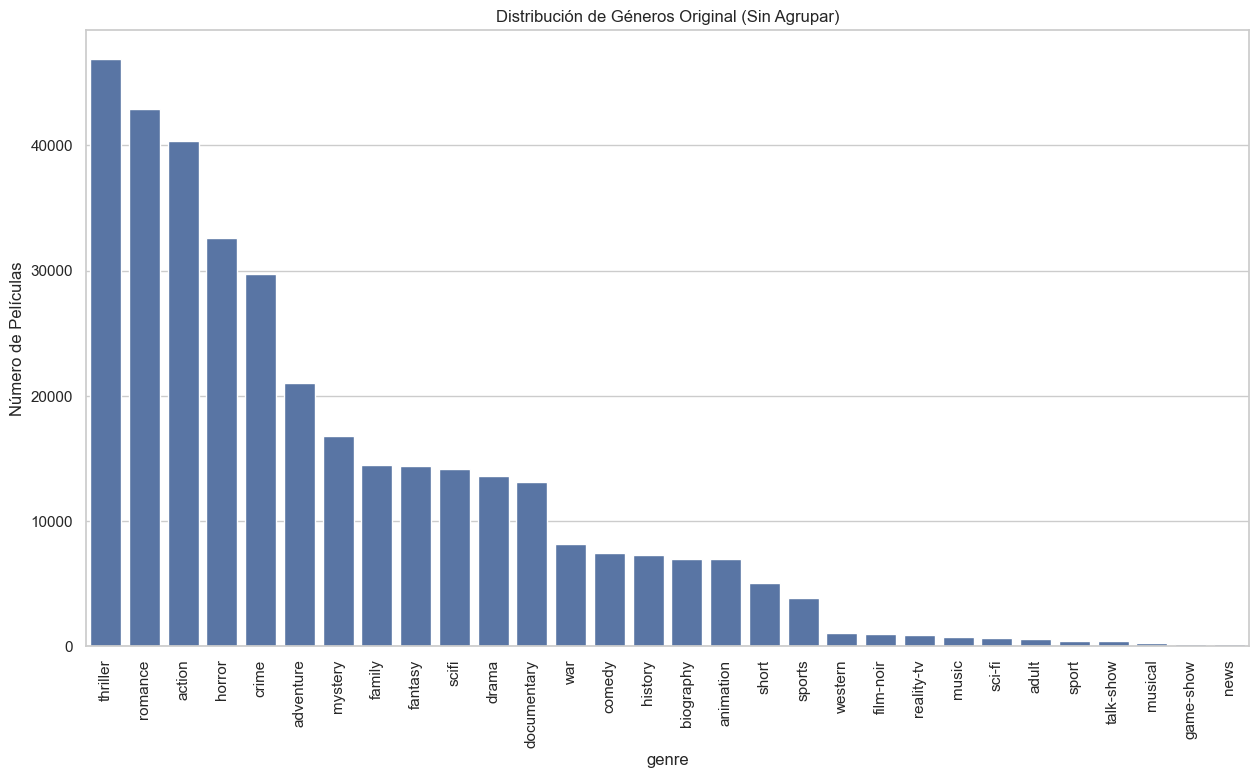

Número de géneros únicos originales: 30


In [20]:
plt.figure(figsize=(15, 8))
genre_counts_raw = df_raw['genre'].value_counts()
sns.barplot(x=genre_counts_raw.index, y=genre_counts_raw.values)
plt.title("Distribución de Géneros Original (Sin Agrupar)")
plt.xticks(rotation=90)
plt.ylabel("Número de Películas")
plt.show()

print(f"Número de géneros únicos originales: {len(genre_counts_raw)}")

Como podemos observar, las clases estan totalmente desbalanceadas antes de tratar los datos. Ademas, hay clases que significan lo mismo pero estan escritas de forma distinta. 

## 3. Aplicación del Mapeo (Harmonización)

Aplicamos el diccionario `LABELS_MAP` definido en la configuración del proyecto para agrupar géneros minoritarios o similares. Tal y como lo hace nuestra clase que se encarga de la limpieza de datos y guardado.

In [21]:
df_mapped = df_raw.copy()

df_mapped["genre_mapped"] = df_mapped["genre"].replace(LABELS_MAP)

initial_len = len(df_mapped)
df_mapped = df_mapped[~df_mapped['text'].str.contains("See full ", na=False)]
print(f"Filas eliminadas por limpieza de texto: {initial_len - len(df_mapped)}")

display(df_mapped[['genre', 'genre_mapped']].sample(10))

Filas eliminadas por limpieza de texto: 75037


,genre,genre_mapped
116183,horror,scifi_horror_fantasy
85170,mystery,suspense_crime
276116,mystery,suspense_crime
200593,adventure,action_adventure
273154,mystery,suspense_crime
170763,horror,scifi_horror_fantasy
38828,comedy,comedy_family
212898,romance,drama_romance
322610,romance,drama_romance
63637,action,action_adventure


## 4. Distribución Post-Mapping

C:\Users\alber\AppData\Local\Temp\ipykernel_6960\167459833.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts_mapped.index, y=genre_counts_mapped.values, palette="viridis")


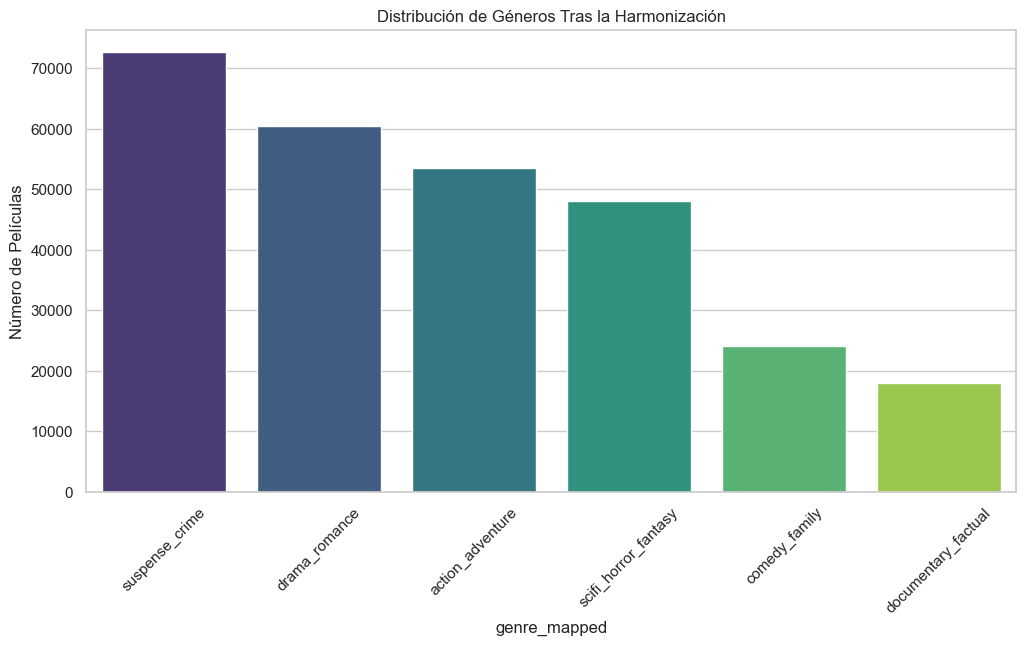

Número de clases finales: 6


In [22]:
plt.figure(figsize=(12, 6))
genre_counts_mapped = df_mapped['genre_mapped'].value_counts()
sns.barplot(x=genre_counts_mapped.index, y=genre_counts_mapped.values, palette="viridis")
plt.title("Distribución de Géneros Tras la Harmonización")
plt.xticks(rotation=45)
plt.ylabel("Número de Películas")
plt.show()

print(f"Número de clases finales: {len(genre_counts_mapped)}")

Como vemos, los datos estan desbalanceados y el modelo ahora si que podra aprender a predecir correctamente los géneros.

## 5. Análisis de Texto

Analizamos la longitud de las descripciones para ver si hay diferencias significativas entre géneros o outliers.

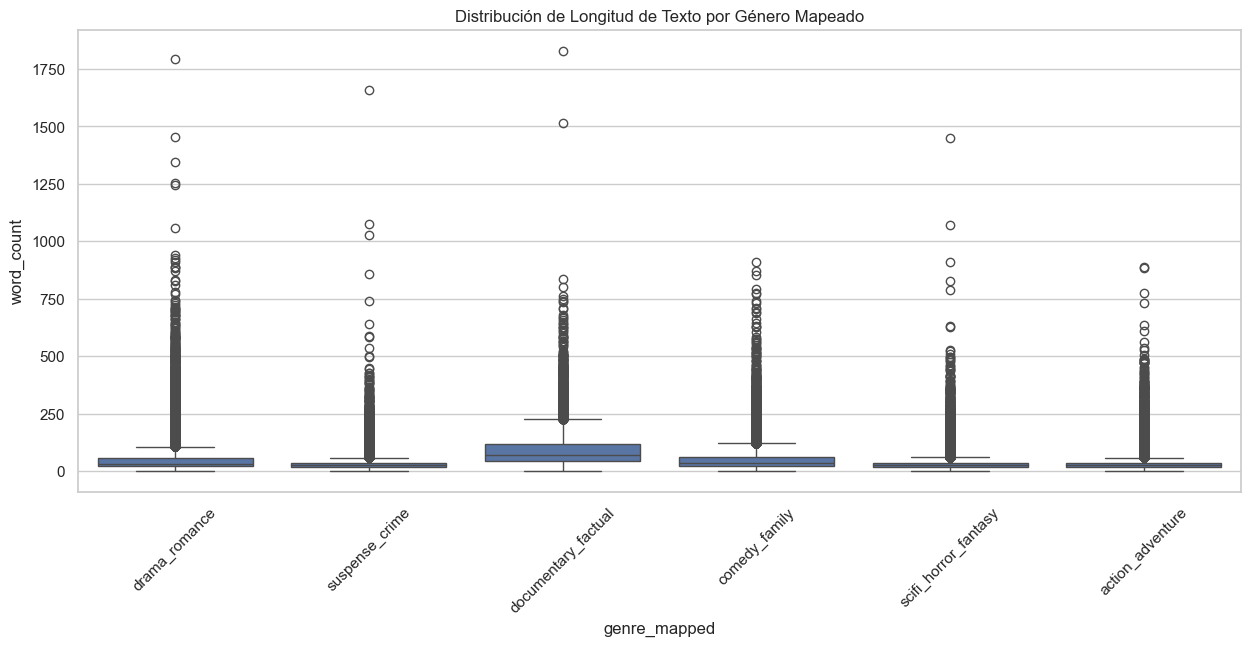

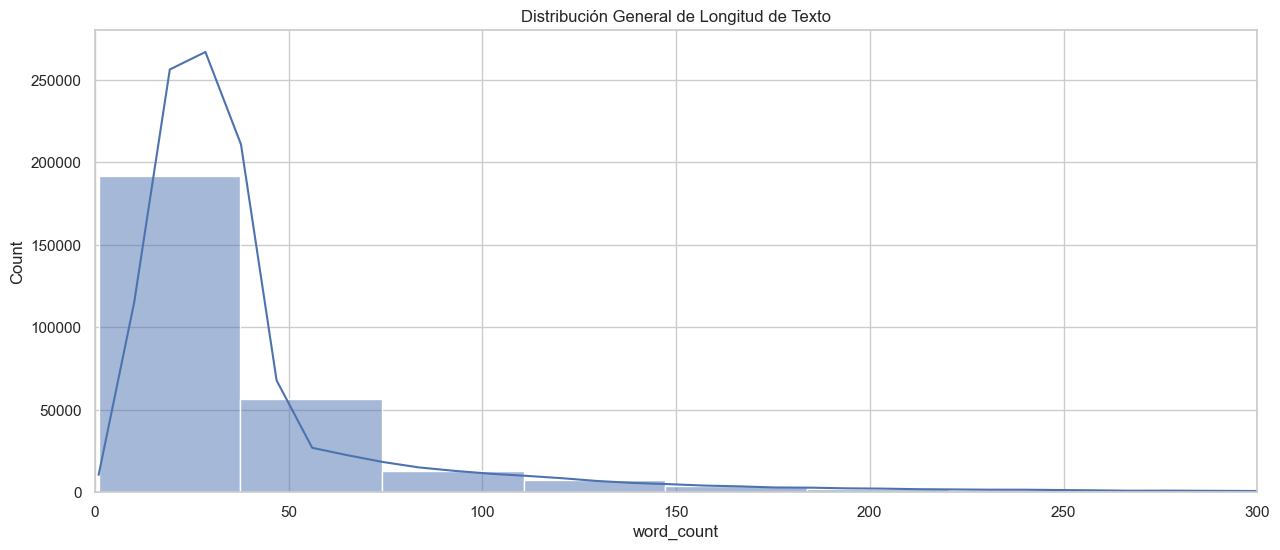

In [23]:
df_mapped['word_count'] = df_mapped['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(15, 6))
sns.boxplot(data=df_mapped, x='genre_mapped', y='word_count')
plt.title("Distribución de Longitud de Texto por Género Mapeado")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 6))
sns.histplot(data=df_mapped, x='word_count', bins=50, kde=True)
plt.title("Distribución General de Longitud de Texto")
plt.xlim(0, 300)
plt.show()

Como podemos observar, la mayoría de los textos tienen una longitud de entre 100 y 200 palabras. Esto nos sera realmente util a la hora de parametrizar nuestro modelo y el preprocesamiento de los datos.

## 6. Verificación de Nulos

In [24]:
nulls = df_mapped.isnull().sum()
print("Valores nulos por columna:")
print(nulls)

Valores nulos por columna:
title           0
text            0
genre           0
genre_mapped    0
word_count      0
dtype: int64
